## Vacuum Neutrino Oscillations

Here is a notebook for homogeneous gas model.

Here we are talking about a homogeneous gas bulk of neutrinos with single energy. The EoM is
$$
i \partial_t \rho_E = \left[ \frac{\delta m^2}{2E}B ,\rho_E \right]
$$

while the EoM for antineutrinos is
$$
i \partial_t \bar\rho_E = \left[- \frac{\delta m^2}{2E}B ,\bar\rho_E \right]
$$

Initial:
Homogeneous, Isotropic, Monoenergetic $\nu_e$ and $\bar\nu_e$

The equations becomes
$$
i \partial_t \rho_E = \left[ \frac{\delta m^2}{2E} B  ,\rho_E \right]
$$
$$
i \partial_t \bar\rho_E = \left[- \frac{\delta m^2}{2E}B,\bar\rho_E \right]
$$



Define $\omega=\frac{\delta m^2}{2E}$,  $\omega = \frac{\delta m^2}{-2E}$, $\mu=\sqrt{2}G_F n_\nu$
$$
i \partial_t \rho_E = \left[ \omega B ,\rho_E \right]
$$
$$
i \partial_t \bar\rho_E = \left[\bar\omega B,\bar\rho_E \right]
$$


where

$$
B = \frac{1}{2} \begin{pmatrix} 
-\cos 2\theta_v & \sin 2\theta_v \\
\sin 2\theta_v & \cos 2\theta_v
\end{pmatrix}
$$

or just use theta =0.2rad


$$
L = \begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix}
$$

Initial condition 
$$
\rho(t=0) = \begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix}
$$

$$
\bar\rho(t=0) =\begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix}
$$

define the following quantities

1. hbar$=\hbar$
%2. delm2E$= \delta m^2/2E$
%3. lamb $= \lambda$, lambb $= \bar\lambda$
%4. gF $= G_F$
%5. mu $=\mu$
6. omega $=\omega$, omegab $=-\bar\omega$

## Numerical

In [1]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline
%load_ext snakeviz

import numpy as np
from scipy.optimize import minimize
from scipy.special import expit
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

import timeit

import pandas as pd

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

In [92]:
# hbar=1.054571726*10**(-34)
hbar=1.0
delm2E=1.0
# lamb=1.0  ## lambda for neutrinos
# lambb=1.0 ## lambda for anti neutrinos
# gF=1.0
# nd=1.0  ## number density
# ndb=1.0   ## number density
omega=1.0
omegab=-1.0

## Here are some matrices to be used

elM = np.array([[1.0,0.0],[0.0,0.0]])
#bM = 1.0/2*np.array( [ [ - 0.38729833462,0.31622776601] , [0.31622776601,0.38729833462] ] )
bM = 1.0/2*np.array( [ [ -np.cos(0.4),np.sin(0.4)] , [np.sin(0.4),np.cos(0.4)] ] )

print bM
## sqareroot of 2
sqrt2=np.sqrt(2.0)

[[-0.4605305   0.19470917]
 [ 0.19470917  0.4605305 ]]


I am going to substitute all density matrix elements using their corrosponding network expressions.

So first of all, I need the network expression for the unknown functions.

A function is written as

$$ y_i= initial+t_i v_k f(t_i w_k+u_k) ,$$

while it's derivative is

$$v_k f(t w_k+u_k) + t v_k f(tw_k+u_k) (1-f(tw_k+u_k)) w_k .$$

Now I can write down the equations using these two forms.

In [93]:
def trigf(x):
    #return 1/(1+np.exp(-x)) # It's not bad to define this function here for people could use other functions other than expit(x).
    return expit(x)

In [94]:
## The time derivative part

### Here are the initial conditions

init = np.array( [[1,0],[0,0]] )
#init = np.array( [[1,2],[3,4]] )

### For neutrinos

def rho(x,ti,initialCondition): # x is the input structure arrays, ti is a time point
    
    elem=np.ones(4)
    
    for i in np.linspace(0,3,4):
        elem[i] = np.sum(ti * x[i*3] * trigf( ti*x[i*3+1] + x[i*3+2] ) )
    
    return initialCondition + np.array([[ elem[0] , elem[1] ],[elem[2], elem[3] ]])


In [95]:
## Test
xtemp=np.ones(120)
rho(xtemp,0,init)

array([[ 1.,  0.],
       [ 0.,  0.]])

In [96]:
## Define Hamiltonians for both

def hamilv():
    return delm2E*bM

In [97]:
## The commutator

def commv(x,ti,initialCondition):
    
    return np.dot(hamilv(), rho(x,ti,initialCondition) ) - np.dot(rho(x,ti,initialCondition), hamilv() )


In [98]:
## Test

print bM

print hamilv()

print "neutrino\n",commv(xtemp,0,init)

[[-0.4605305   0.19470917]
 [ 0.19470917  0.4605305 ]]
[[-0.4605305   0.19470917]
 [ 0.19470917  0.4605305 ]]
neutrino
[[ 0.         -0.19470917]
 [ 0.19470917  0.        ]]


A function is written as

$$ y_i= initial+t_i v_k f(t_i w_k+u_k) ,$$

while it's derivative is

$$v_k f(t w_k+u_k) + t v_k f(tw_k+u_k) (1-f(tw_k+u_k)) w_k .$$

In [124]:
## The COST of the eqn set

regularization = 0.0001
npsum = np.sum

def costvTi(x,ti,initialCondition): # l is total length of x
    
    list = np.linspace(0,3,4)

    fvec = []
    costi = np.ones(4) + 1.0j* np.ones(4)
    commvi = np.array([commv(x,ti,initialCondition)[0,0],commv(x,ti,initialCondition)[0,1],commv(x,ti,initialCondition)[1,0],commv(x,ti,initialCondition)[1,1] ])
    
    fvecappend = fvec.append
    
    for i in list:
        fvecappend(np.asarray(trigf(ti*1.0*x[i*3+1] + 1.0*x[i*3+2]) ) )
        
    fvec = np.array(fvec)
    
    for i in list:
        costi[i] = ( np.sum (1.0*x[i*3]*fvec[i] + 1.0*ti * x[i*3]* fvec[i] * ( 1.0 -  fvec[i]  ) * x[i*3+1] ) + 1.0j*  ( commvi[i] )  )  

    costiTemp = 0.0
    
    for i in list:
        costiTemp = costiTemp + (np.real(costi[i]))**2 + (np.imag(costi[i]))**2

    
    return costiTemp
    
    #return np.abs(np.real(costi11)) + np.abs(np.real(costi12))+ np.abs(np.real(costi21)) +  np.abs(np.real(costi22)) + np.abs(np.imag(costi11)) + np.abs(np.imag(costi12))+ np.abs(np.imag(costi21)) +  np.abs(np.imag(costi22))

    #return ( (np.real(costi11))**2 + (np.real(costi12))**2+ (np.real(costi21))**2 +  (np.real(costi22))**2 + (np.imag(costi11))**2 + (np.imag(costi12))**2+ (np.imag(costi21))**2 +  (np.imag(costi22))**2 )/v11.size + regularization * ( np.sum(v11**2)+np.sum(v12**2)+np.sum(v21**2) + np.sum(v22**2) + np.sum(w11**2) + np.sum(w12**2)+ np.sum(w21**2)+ np.sum(w22**2) )



def CostOfStructure(x):
    
    v11,w11,u11,v12,w12,u12,v21,w21,u21,v22,w22,u22 = x[:12]
    
    return regularization * ( np.sum(v11**2)+np.sum(v12**2)+np.sum(v21**2) + np.sum(v22**2) + np.sum(w11**2) + np.sum(w12**2)+ np.sum(w21**2)+ np.sum(w22**2) )

In [125]:
print costvTi(xtemp,2,init), costvTi2(xtemp,2,init)

11.9516331412 11.9516331412


In [102]:
## Calculate the total cost

def costv(x,t,initialCondition):

    t = np.array(t)
    
    costvTotal = np.sum( costvTList(x,t,initialCondition)  )
        
    return costvTotal
    

def costvTList(x,t,initialCondition):  ## This is the function WITHOUT the square!!! 
        
    t = np.array(t)
    
    costvList = np.asarray([])
    
    for temp in t:
        tempElement = costvTi(x,temp,initialCondition)
        costvList = np.append(costvList, tempElement)
        
    return np.array(costvList)

    

In [103]:
ttemp = np.linspace(0,10)
print ttemp

[  0.           0.20408163   0.40816327   0.6122449    0.81632653
   1.02040816   1.2244898    1.42857143   1.63265306   1.83673469
   2.04081633   2.24489796   2.44897959   2.65306122   2.85714286
   3.06122449   3.26530612   3.46938776   3.67346939   3.87755102
   4.08163265   4.28571429   4.48979592   4.69387755   4.89795918
   5.10204082   5.30612245   5.51020408   5.71428571   5.91836735
   6.12244898   6.32653061   6.53061224   6.73469388   6.93877551
   7.14285714   7.34693878   7.55102041   7.75510204   7.95918367
   8.16326531   8.36734694   8.57142857   8.7755102    8.97959184
   9.18367347   9.3877551    9.59183673   9.79591837  10.        ]


In [104]:
ttemp = np.linspace(0,10)
print costvTList(xtemp,ttemp,init)
print costv(xtemp,ttemp,init)

[   2.2136099     2.82542057    3.50674411    4.25935949    5.08963359
    6.00708951    7.02267217    8.14722876    9.39045557   10.76034338
   12.26302826   13.90291194   15.68292596   17.6048451    19.66959072
   21.87749312   24.22850159   26.72234275   29.35863356   32.13695768
   35.05691384   38.11814371   41.32034556   44.66327835   48.14675997
   51.77066195   55.5349025    59.43943894   63.48426033   67.66938059
   71.99483247   76.46066233   81.06692578   85.81368417   90.70100169
   95.72894325  100.89757274  106.20695188  111.65713932  117.2481901
  122.98015532  128.85308201  134.8670131   141.02198754  147.31804043
  153.75520324  160.33350408  167.05296793  173.91361689  180.91547049]
3226.66081823


## Jacobian

def commvprimew(x,ti,initialCondition): # this is the prime of commutator with respect to w.
     
    return cprimew

def costvJaci(x,ti,initialCondition):
    
    v11,w11,u11,v12,w12,u12,v21,w21,u21,v22,w22,u22 = x[:12]
    
    out = np.zeros(12)

    fvec11 = np.array(trigf(ti*w11 + u11) )  # This is a vector!!!
    fvec12 = np.array(trigf(ti*w12 + u12) )
    fvec21 = np.array(trigf(ti*w21 + u21) )
    fvec22 = np.array(trigf(ti*w22 + u22) )

    fvec11w = np.array( ti*fvec11 * ( 1- fvec11 ) * w11 )  # This is a vector!!!
    fvec12w = np.array( ti*fvec12 * ( 1- fvec12 ) * w12 ) 
    fvec21w = np.array( ti*fvec21 * ( 1- fvec21 ) * w21 ) 
    fvec22w = np.array( ti*fvec22 * ( 1- fvec22 ) * w22 ) 

    fvec11u = np.array( fvec11 * ( 1- fvec11 ) * u11 )  # This is a vector!!!
    fvec12u = np.array( fvec12 * ( 1- fvec12 ) * u12 ) 
    fvec21u = np.array( fvec21 * ( 1- fvec21 ) * u21 ) 
    fvec22u = np.array( fvec22 * ( 1- fvec22 ) * u22 ) 

    rt11= initialCondition[0,0] + np.sum(ti * v11 * fvec11 )
    rt12= initialCondition[0,1] + np.sum(ti * v12 * fvec12 )
    rt21= initialCondition[1,0] + np.sum(ti * v21 * fvec21 )
    rt22= initialCondition[1,1] + np.sum(ti * v22 * fvec22 )

    costi11= ( np.sum (v11*fvec11 + ti * v11* fvec11 * ( 1 -  fvec11  ) * w11 ) + 1.0j*  ( commv(x,ti,initialCondition)[0,0] )  )  
    costi12= ( np.sum (v12*fvec12 + ti * v12* fvec12 * ( 1 -  fvec12  ) * w12 ) + 1.0j*  ( commv(x,ti,initialCondition)[0,1] )  )  
    costi21= ( np.sum (v21*fvec21 + ti * v21* fvec21 * ( 1 -  fvec21  ) * w21 ) + 1.0j*  ( commv(x,ti,initialCondition)[1,0] )  )  
    costi22= ( np.sum (v22*fvec22 + ti * v22* fvec22 * ( 1 -  fvec22  ) * w22 ) + 1.0j*  ( commv(x,ti,initialCondition)[1,1] )  )  
    
    funprime11w = np.sum (v11*fvec11w + ti * v11* fvec11w * ( 1 -  fvec11  ) * w11 + ti * v11* fvec11 * ( 1 -  fvec11  ) - ti * v11 * fvec11 * fvec11w * w11 )
    funprime12w = np.sum (v12*fvec12w + ti * v12* fvec12w * ( 1 -  fvec12  ) * w12 + ti * v12* fvec12 * ( 1 -  fvec12  ) - ti * v12 * fvec12 * fvec12w * w12 )
    funprime21w = np.sum (v21*fvec21w + ti * v21* fvec21w * ( 1 -  fvec21  ) * w21 + ti * v21* fvec21 * ( 1 -  fvec21  ) - ti * v21 * fvec21 * fvec21w * w21 )
    funprime22w = np.sum (v22*fvec22w + ti * v22* fvec22w * ( 1 -  fvec22  ) * w22 + ti * v22* fvec22 * ( 1 -  fvec22  ) - ti * v22 * fvec22 * fvec22w * w22 )
    
    commvprime11w = commv(x,ti,initialCondition)[0,1]
    
    #costi11pw = ( funprime11w + 1.0j *  ( commvprimew(x,ti,initialCondition)[0,0]   )  )
    #costi12pw = ( funprime12w + 1.0j *  (  commvprimew(x,ti,initialCondition)[0,1]  )  )  
    #costi21pw = ( funprime21w + 1.0j *  ( commvprimew(x,ti,initialCondition)[1,0] )  )  
    #costi22pw = ( funprime22w + 1.0j *  ( commvprimew(x,ti,initialCondition)[1,1] )  )  
    
    costi11pw = ( funprime11w + 1.0j *  ( commvprimew(x,ti,initialCondition)[0,0]   )  )
    costi12pw = ( funprime12w + 1.0j *  (  commvprimew(x,ti,initialCondition)[0,1]  )  )  
    costi21pw = ( funprime21w + 1.0j *  ( commvprimew(x,ti,initialCondition)[1,0] )  )  
    costi22pw = ( funprime22w + 1.0j *  ( commvprimew(x,ti,initialCondition)[1,1] )  )  
    
    
    return np.array(out)

def costvJac(v,w,u,t):
    v = np.array(v)
    w = np.array(w)
    u = np.array(u)
    
    vout = 0
    wout = 0
    uout = 0
    
    for temp in t:
        vout = vout + 2*mhelper(v,w,u,temp)*vhelper(v,w,u,temp)
        wout = wout + 2*mhelper(v,w,u,temp)*whelper(v,w,u,temp)
        uout = uout + 2*mhelper(v,w,u,temp)*uhelper(v,w,u,temp)
    
    out = np.hstack((vout,wout,uout))
    
    return np.array(out)

## Minimization

Here is the minimization

In [105]:
tlin = np.linspace(0,10,10)
# tlinTest = np.linspace(0,14,10) + 0.5
# initGuess = np.ones(120)
# initGuess = np.asarray(np.split(np.random.rand(1,720)[0],12))
initGuess = np.asarray(np.split(np.random.rand(1,60)[0],12))
    


costvF = lambda x: costv(x,tlin,init)
#costvFTest = lambda x: costv(x,tlinTest,init)

In [106]:
print costv(initGuess,tlin,init)#, costv(initGuess,tlinTest,init)

1487.99577436


In [107]:
## %%snakeviz
# startCG = timeit.default_timer()
#costvFResultCG = minimize(costvF,initGuess,method="CG")
#stopCG = timeit.default_timer()

#print stopCG - startCG

#print costvFResultCG

%%snakeviz
startNM = timeit.default_timer()
costvFResultNM = minimize(costvF,initGuess,method="Nelder-Mead",options={"maxfun":20000})
stopNM = timeit.default_timer()

print stopNM - startNM

print costvFResultNM

initGuessIter = costvFResultNM.get("x")

for TOLERANCE in np.asarray([1e-8,1e-9,1e-12,1e-14,1e-16,1e-19,1e-20,1e-21,1e-22]):
    costvFResultNMIter = minimize(costvF,initGuessIter,method="Nelder-Mead",tol=TOLERANCE,options={"maxfun":90000,"maxiter":900000})
    initGuessIter = costvFResultNMIter.get("x")
    print TOLERANCE,costvFResultNMIter

In [108]:
#%%snakeviz
#startBFGS = timeit.default_timer()
#costvFResultBFGS = minimize(costvF,initGuess,method="BFGS")
#stopBFGS = timeit.default_timer()

#print stopBFGS - startBFGS

#print costvFResultBFGS

initGuessIter = initGuess

for TOLERANCE in np.asarray([1e-19,1e-20,1e-21,1e-22]):
    costvFResultSLSQP = minimize(costvF,initGuessIter,method="SLSQP",tol=TOLERANCE)
    initGuessIter = costvFResultSLSQP.get("x")
    print TOLERANCE,costvFResultSLSQP

In [109]:
%%snakeviz
startSLSQP = timeit.default_timer()
costvFResultSLSQP = minimize(costvF,initGuess,method="SLSQP",tol=1e-10)
stopSLSQP = timeit.default_timer()

print stopSLSQP - startSLSQP

print costvFResultSLSQP

59.4442219734
  status: 0
 success: True
    njev: 51
    nfev: 3174
     fun: 0.28917217200293521
       x: array([ -5.44851228e-02,   2.79892128e+01,  -1.24370743e+01,
        -6.23813582e-03,   2.08247473e+01,   1.23003675e+01,
         3.10448806e+00,  -3.36350119e+00,  -1.75085282e+01,
         5.44850653e-02,   2.72891168e+01,  -1.10588144e+01,
         2.06842411e-01,   3.71516793e-01,   4.42953041e-01,
         4.09312972e-01,   4.69538390e-01,   4.85402206e-01,
         2.81039273e-01,   6.77679697e-01,   2.52299185e-01,
         2.67446298e-03,   4.57328005e-01,   2.84634334e-01,
         1.37886240e-02,   1.73553559e-01,   3.53048530e-01,
         7.45781077e-01,   8.14907193e-01,   3.15614028e-01,
         6.32704308e-02,   3.92412308e-01,   6.47945672e-01,
         3.10839879e-01,   1.04914155e-01,   1.46859914e-01,
         4.49436714e-01,   8.58022257e-01,   6.77305399e-01,
         9.32723047e-02,   7.67227509e-01,   3.88149880e-01,
         6.14422293e-01,   2.92083554

In [110]:
#%%snakeviz
#startSLSQPTest = timeit.default_timer()
#costvFResultSLSQPTest = minimize(costvFTest,initGuess,method="SLSQP")
#stopSLSQPTest = timeit.default_timer()

#print stopSLSQPTest - startSLSQPTest

#print costvFResultSLSQPTest

In [111]:
print costvFResultSLSQP.get('x')
print np.asarray(np.split(costvFResultSLSQP.get('x'),12))
print CostOfStructure(np.asarray(np.split(costvFResultSLSQP.get('x'),12)))

[ -5.44851228e-02   2.79892128e+01  -1.24370743e+01  -6.23813582e-03
   2.08247473e+01   1.23003675e+01   3.10448806e+00  -3.36350119e+00
  -1.75085282e+01   5.44850653e-02   2.72891168e+01  -1.10588144e+01
   2.06842411e-01   3.71516793e-01   4.42953041e-01   4.09312972e-01
   4.69538390e-01   4.85402206e-01   2.81039273e-01   6.77679697e-01
   2.52299185e-01   2.67446298e-03   4.57328005e-01   2.84634334e-01
   1.37886240e-02   1.73553559e-01   3.53048530e-01   7.45781077e-01
   8.14907193e-01   3.15614028e-01   6.32704308e-02   3.92412308e-01
   6.47945672e-01   3.10839879e-01   1.04914155e-01   1.46859914e-01
   4.49436714e-01   8.58022257e-01   6.77305399e-01   9.32723047e-02
   7.67227509e-01   3.88149880e-01   6.14422293e-01   2.92083554e-01
   4.41417286e-01   1.20828517e-01   7.39381855e-01   6.41867842e-01
   6.02782521e-01   9.48355576e-01   2.74875353e-01   8.51261167e-01
   3.67914102e-01   5.98250618e-01   9.13689197e-01   3.01212466e-01
   2.71666043e-01   1.80152269e-01

In [112]:
#np.savetxt('./assets/homogen/optimize_ResultSLSQPT2120_Vac.txt', costvFResultSLSQP.get('x'), delimiter = ',')

## Functions

Find the solutions to each elements.

In [113]:
# costvFResultSLSQPx = np.genfromtxt('./assets/homogen/optimize_ResultSLSQP.txt', delimiter = ',')

In [114]:
## The first element of neutrino density matrix
xresult = np.asarray(costvFResultSLSQP.get('x'))
#xresult = np.asarray(costvFResultNM.get('x'))
#xresult = np.asarray(costvFResultBFGS.get('x'))

print xresult

plttlin=np.linspace(0,10,100)

pltdata11 = np.array([])
pltdata11Test = np.array([])
pltdata22 = np.array([])
pltdata12 = np.array([])
pltdata21 = np.array([])

for i in plttlin:
    pltdata11 = np.append(pltdata11 ,rho(xresult,i,init)[0,0] )
    
print pltdata11

for i in plttlin:
    pltdata12 = np.append(pltdata12 ,rho(xresult,i,init)[0,1] )
    
print pltdata12

for i in plttlin:
    pltdata21 = np.append(pltdata21 ,rho(xresult,i,init)[1,0] )
    
print pltdata21

#for i in plttlin:
#    pltdata11Test = np.append(pltdata11Test ,rho(xresultTest,i,init)[0,0] )
#    
#print pltdata11Test


for i in plttlin:
    pltdata22 = np.append(pltdata22 ,rho(xresult,i,init)[1,1] )
    
print pltdata22

print rho(xresult,0,init)

[ -5.44851228e-02   2.79892128e+01  -1.24370743e+01  -6.23813582e-03
   2.08247473e+01   1.23003675e+01   3.10448806e+00  -3.36350119e+00
  -1.75085282e+01   5.44850653e-02   2.72891168e+01  -1.10588144e+01
   2.06842411e-01   3.71516793e-01   4.42953041e-01   4.09312972e-01
   4.69538390e-01   4.85402206e-01   2.81039273e-01   6.77679697e-01
   2.52299185e-01   2.67446298e-03   4.57328005e-01   2.84634334e-01
   1.37886240e-02   1.73553559e-01   3.53048530e-01   7.45781077e-01
   8.14907193e-01   3.15614028e-01   6.32704308e-02   3.92412308e-01
   6.47945672e-01   3.10839879e-01   1.04914155e-01   1.46859914e-01
   4.49436714e-01   8.58022257e-01   6.77305399e-01   9.32723047e-02
   7.67227509e-01   3.88149880e-01   6.14422293e-01   2.92083554e-01
   4.41417286e-01   1.20828517e-01   7.39381855e-01   6.41867842e-01
   6.02782521e-01   9.48355576e-01   2.74875353e-01   8.51261167e-01
   3.67914102e-01   5.98250618e-01   9.13689197e-01   3.01212466e-01
   2.71666043e-01   1.80152269e-01

In [115]:
rho(xresult,1,init)

array([[  9.45514887e-01,  -6.23813582e-03],
       [  2.67536366e-09,   5.44850604e-02]])

In [116]:
#np.savetxt('./assets/homogen/optimize_pltdatar11.txt', pltdata11, delimiter = ',')
#np.savetxt('./assets/homogen/optimize_pltdatar22.txt', pltdata22, delimiter = ',')

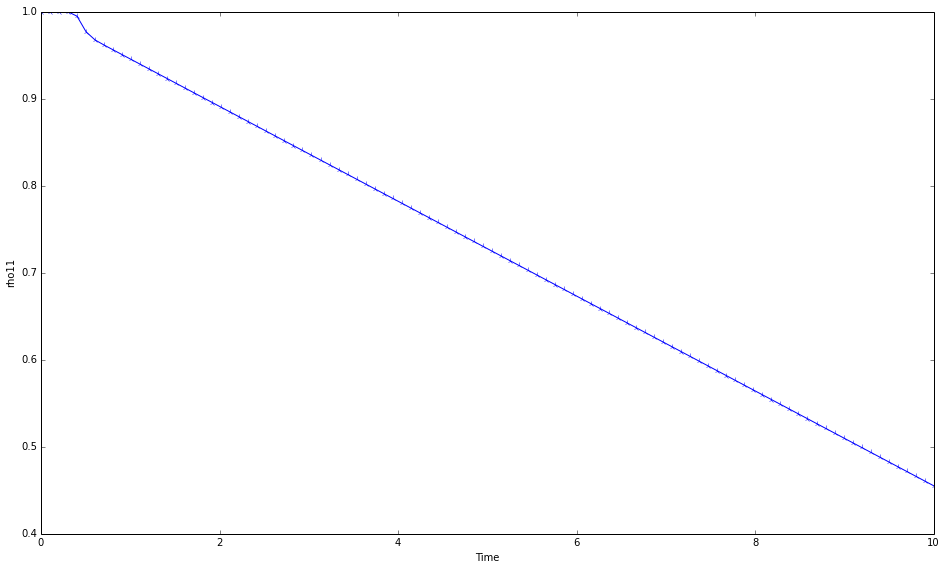

In [117]:
plt.figure(figsize=(16,9.36))
plt.ylabel('rho11')
plt.xlabel('Time')
plt11=plt.plot(plttlin,pltdata11,"b4-",label="vac_rho11")
#plt.plot(plttlin,pltdata11Test,"m4-",label="vac_rho11Test")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="vac_HG-rho11")


# tls.embed("https://plot.ly/~emptymalei/73/")

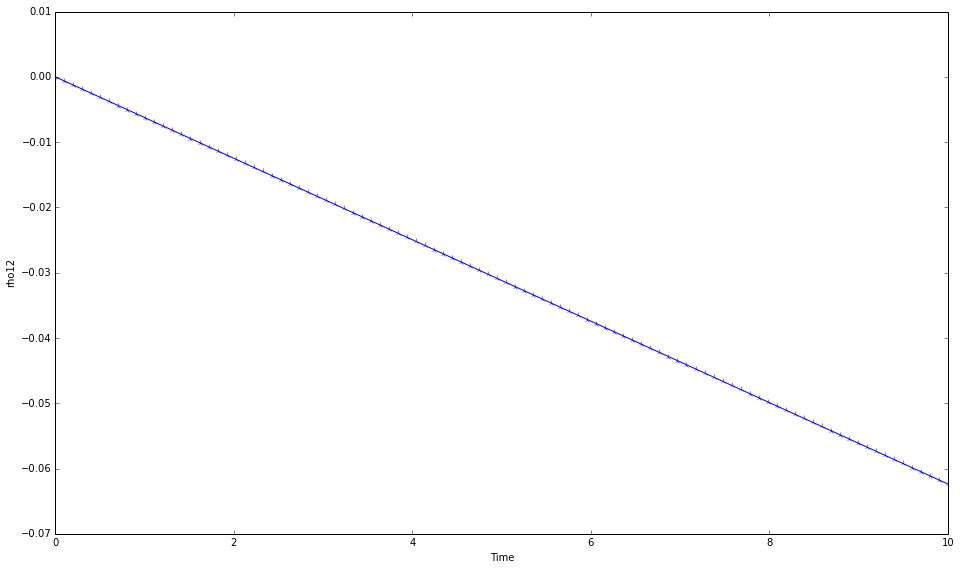

In [118]:
plt.figure(figsize=(16,9.36))
plt.ylabel('rho12')
plt.xlabel('Time')
plt12=plt.plot(plttlin,pltdata12,"b4-",label="vac_rho12")
#plt.plot(plttlin,pltdata11Test,"m4-",label="vac_rho11Test")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="vac_HG-rho11")


# tls.embed("https://plot.ly/~emptymalei/73/")

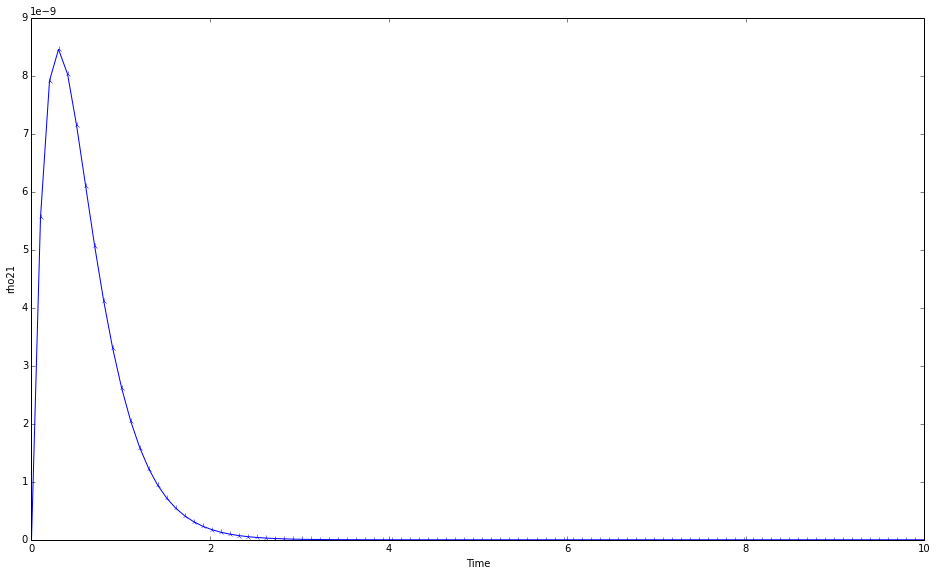

In [119]:
plt.figure(figsize=(16,9.36))
plt.ylabel('rho21')
plt.xlabel('Time')
plt11=plt.plot(plttlin,pltdata21,"b4-",label="vac_rho21")
#plt.plot(plttlin,pltdata11Test,"m4-",label="vac_rho11Test")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="vac_HG-rho11")


# tls.embed("https://plot.ly/~emptymalei/73/")

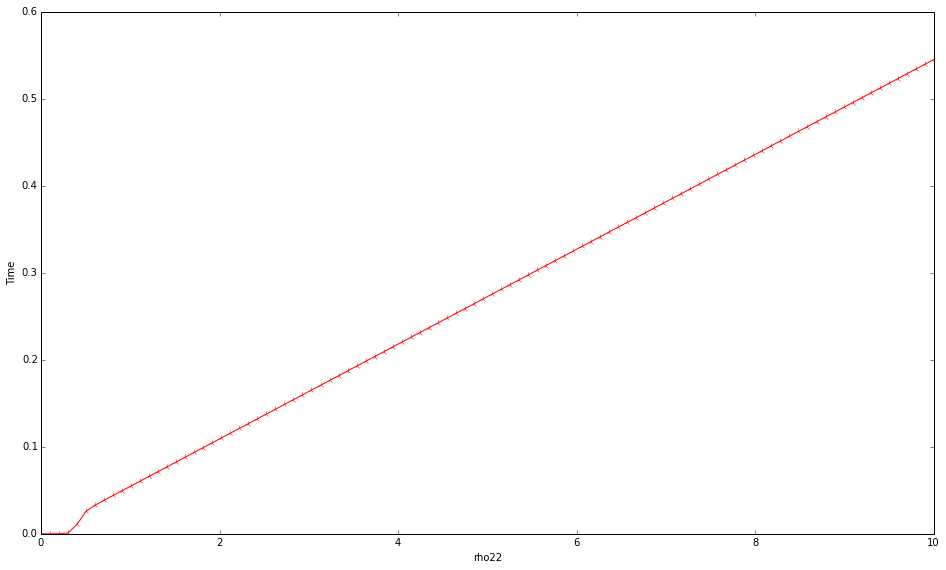

In [120]:
plt.figure(figsize=(16,9.36))
plt.ylabel('Time')
plt.xlabel('rho22')
plt22=plt.plot(plttlin,pltdata22,"r4-",label="vac_rho22")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="vac_HG-rho22")

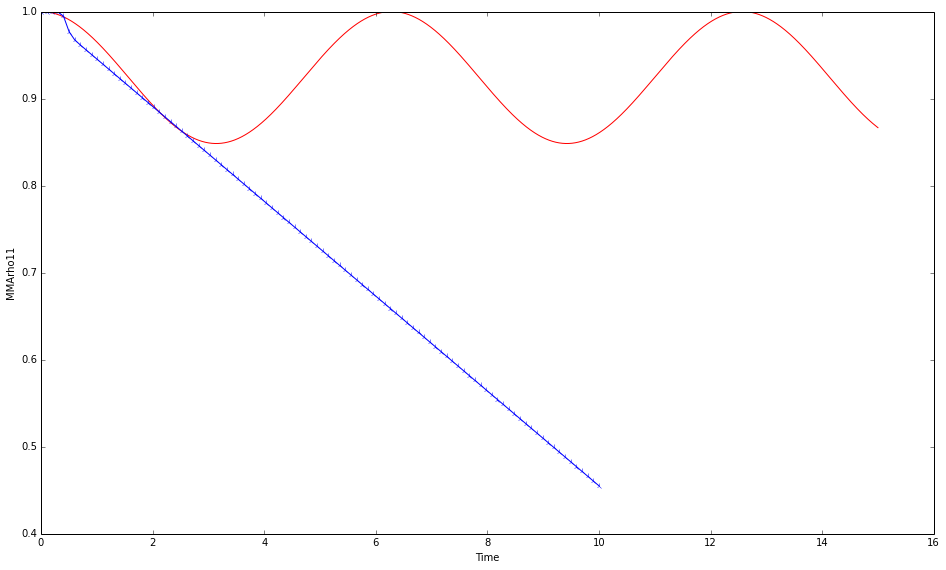

In [121]:
MMA_optmize_Vac_pltdata = np.genfromtxt('./assets/homogen/MMA_optmize_Vac_pltdata.txt', delimiter = ',')

plt.figure(figsize=(16,9.36))
plt.ylabel('MMArho11')
plt.xlabel('Time')
plt.plot(np.linspace(0,15,4501),MMA_optmize_Vac_pltdata,"r-",label="MMAVacrho11")
plt.plot(plttlin,pltdata11,"b4-",label="vac_rho11")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="MMA-rho11-Vac-80-60")

## Practice

In [ ]:
xtemp1 = np.arange(4)
xtemp1.shape = (2,2)
print xtemp1
xtemp1[0,1]
np.dot(xtemp1,xtemp1)
xtemp1[0,1]